<p style="font-family:Verdana; font-size: 26px; color: magenta"> 8.0 - Rainfall Prediction</p>

 
<p style="font-family:Verdana; font-size: 18px; color: darkorange"> 1. -
</p>

<p style="font-family:Verdana; font-size: 18px; color: orange"> Step 1: Import Libraries</p>

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 2: Loading the Data</p>

In [49]:
# Ihe dataset contains 284,807 transactions with 31 features including:
try:
    df = pd.read_csv('../../data/Rainfall.csv')
except Exception as e:
    print(f"Error loading dataset: {e}")
 
df.head(3)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2


In [50]:
df.shape

(366, 12)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     366 non-null    int64  
 1   pressure                366 non-null    float64
 2   maxtemp                 366 non-null    float64
 3   temparature             366 non-null    float64
 4   mintemp                 366 non-null    float64
 5   dewpoint                366 non-null    float64
 6   humidity                366 non-null    int64  
 7   cloud                   366 non-null    int64  
 8   rainfall                366 non-null    object 
 9   sunshine                366 non-null    float64
 10           winddirection  365 non-null    float64
 11  windspeed               365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


In [52]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
day,366.0,15.756831,8.823592,1.0,8.000,16.00,23.000,31.0
pressure,366.0,1013.742623,6.414776,998.5,1008.500,1013.00,1018.100,1034.6
maxtemp,366.0,26.191257,5.978343,7.1,21.200,27.75,31.200,36.3
temparature,366.0,23.747268,5.632813,4.9,18.825,25.45,28.600,32.4
mintemp,366.0,21.894536,5.594153,3.1,17.125,23.70,26.575,30.0
dewpoint,366.0,19.989071,5.997021,-0.4,16.125,21.95,25.000,26.7
humidity,366.0,80.177596,10.062470,36.0,75.000,80.50,87.000,98.0
cloud,366.0,71.128415,21.798012,0.0,58.000,80.00,88.000,100.0
sunshine,366.0,4.419399,3.934398,0.0,0.500,3.50,8.200,12.1
winddirection,365.0,101.506849,81.723724,10.0,40.000,70.00,190.000,350.0


<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 3: Data Cleaning</p>

In [53]:
# To check the null values in the dataset.
for col in df.columns:
    temp = df[col].isnull().sum()
    if temp > 0:
        print(f'Column {col} contains {temp} null values.')

Column          winddirection contains 1 null values.
Column windspeed contains 1 null values.


In [54]:
# df = df.dropna()
# print("Total values in the dataset after removing the null values:", len(df))

In [55]:
df.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

In [56]:
# Here we can observe that there are unnecessary spaces in the names of the columns let's remove that.
df.rename(str.strip,
          axis='columns', 
          inplace=True)

df.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

In [57]:
# Now it's time for null value imputation.
for col in df.columns:
  
  # Checking if the column contains
  # any null values
  if df[col].isnull().sum() > 0:
    val = df[col].mean()
    df[col] = df[col].fillna(val)
    
df.isnull().sum().sum()

0

<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 4: Exploratory Data Analysis</p>

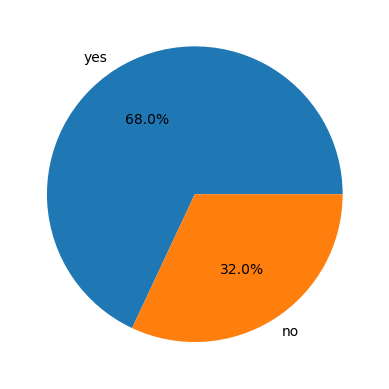

In [58]:
# Data visualization is the graphical representation of information and data in a pictorial or graphical format. 
plt.pie(df['rainfall'].value_counts().values,
        labels = df['rainfall'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

> maxtemp is relatively lower on days of rainfall.

>> dewpoint value is higher on days of rainfall.

> humidity is high on the days when rainfall is expected.

>> Obviously, clouds must be there for rainfall.

> sunshine is also less on days of rainfall.

>> windspeed is higher on days of rainfall.

In [59]:
features = list(df.select_dtypes(include = np.number).columns)
features.remove('day')
print(features)

['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


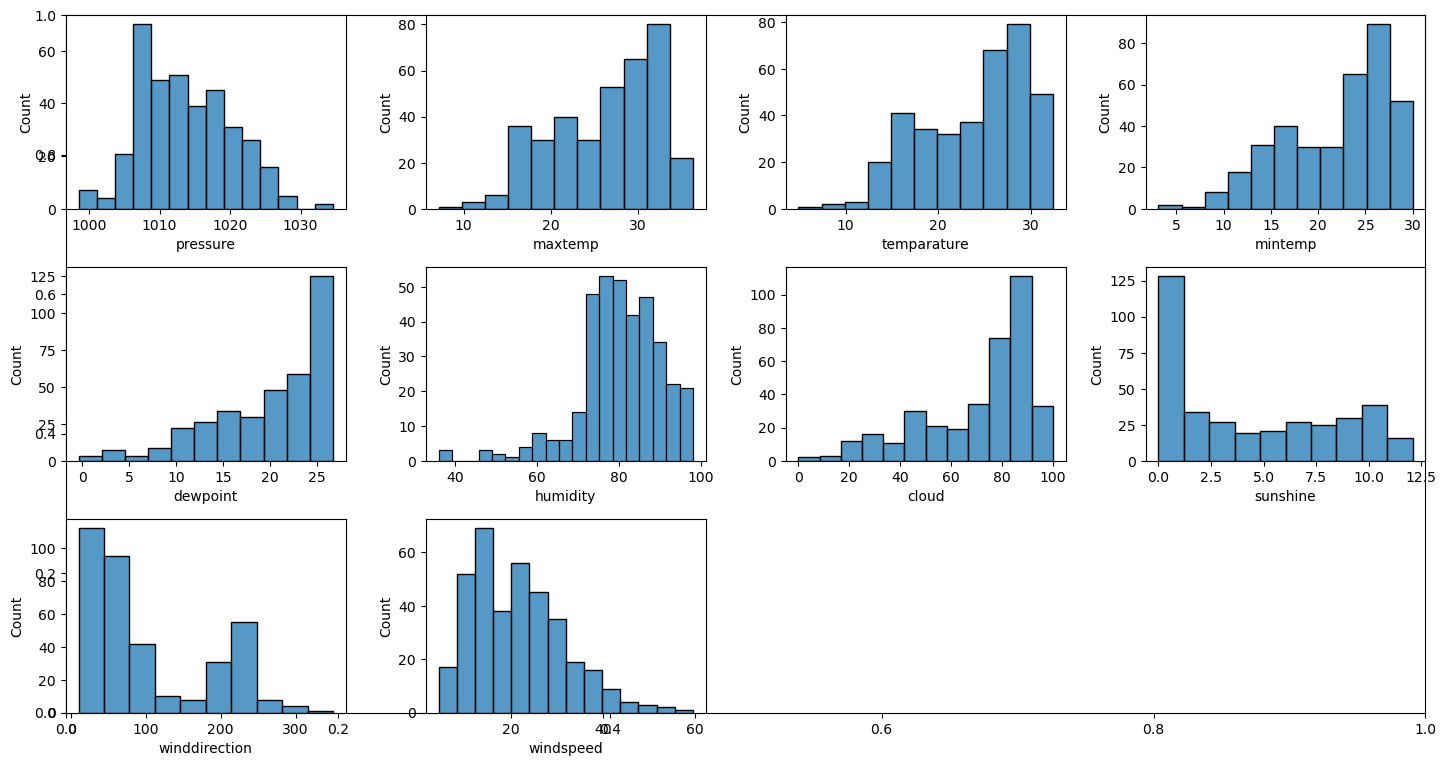

In [60]:
# Let's check the distribution of the continuous features given in the dataset.
plt.subplots(figsize=(15,8))

for i, col in enumerate(features):
  plt.subplot(3,4, i + 1)
  sb.histplot(df[col])
plt.tight_layout()
plt.show()

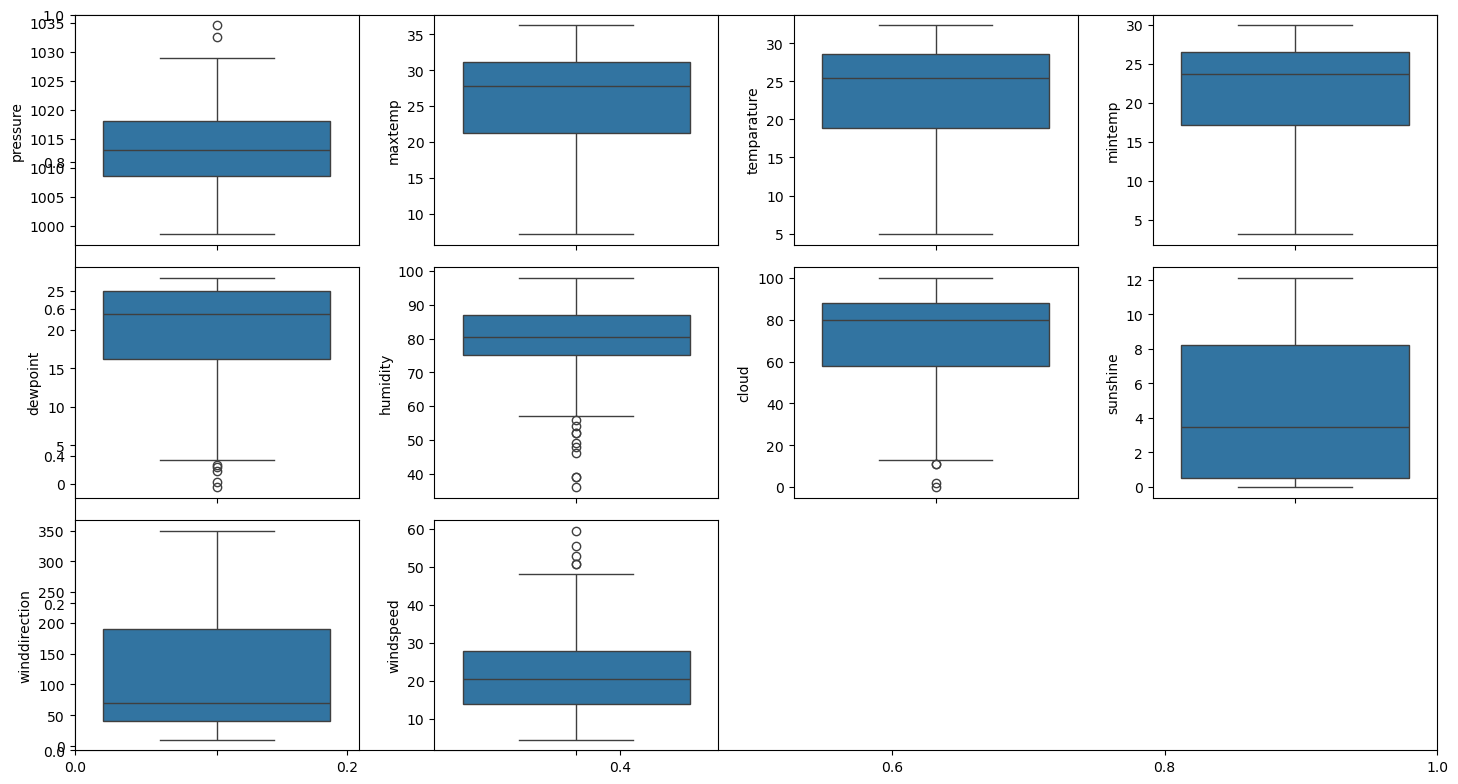

In [61]:
# Let's draw boxplots for the continuous variable to detect the outliers present in the data.
plt.subplots(figsize=(15,8))

for i, col in enumerate(features):
  plt.subplot(3,4, i + 1)
  sb.boxplot(df[col])
plt.tight_layout()
plt.show()

In [62]:
# There are outliers in the data but sadly we do not have much data so, we cannot remove this.
df.sample(3, random_state=11)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
262,19,1012.2,30.6,28.3,26.8,24.3,79,67,no,3.8,180.0,8.1
154,3,1006.5,32.4,30.3,29.0,26.5,80,77,yes,5.2,220.0,28.8
249,6,1008.1,32.3,29.6,27.8,25.6,79,43,no,9.7,240.0,24.9


In [63]:
df.replace({'yes':1, 'no':0}, inplace=True)

In [64]:
df.sample(3, random_state=11)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
262,19,1012.2,30.6,28.3,26.8,24.3,79,67,0,3.8,180.0,8.1
154,3,1006.5,32.4,30.3,29.0,26.5,80,77,1,5.2,220.0,28.8
249,6,1008.1,32.3,29.6,27.8,25.6,79,43,0,9.7,240.0,24.9


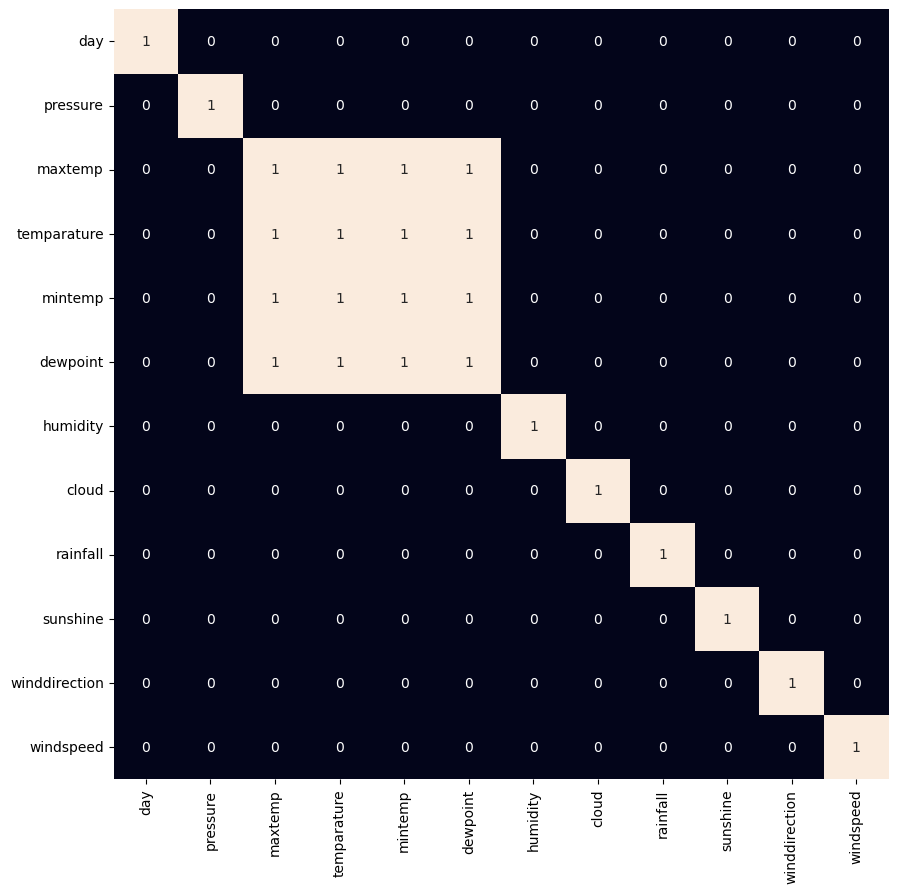

In [65]:
# Sometimes there are highly correlated features that just increase the dimensionality 
# of the feature space and do not good for the model's performance. 
# So we must check whether there are highly correlated features in this dataset or not.
plt.figure(figsize=(10,10))
# Compute pairwise correlation of columns, excluding NA/null values.
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

In [66]:
# Now we will remove the highly correlated features 'maxtemp' and 'mintemp'.

# But why not temp or dewpoint? 
# This is because temp and dewpoint provide distinct information regarding the weather and atmospheric conditions.
df.drop(['maxtemp', 'mintemp'], axis=1, inplace=True)
df.sample(3, random_state=11)

,day,pressure,temparature,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
262,19,1012.2,28.3,24.3,79,67,0,3.8,180.0,8.1
154,3,1006.5,30.3,26.5,80,77,1,5.2,220.0,28.8
249,6,1008.1,29.6,25.6,79,43,0,9.7,240.0,24.9


<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 5: Model Training</p>

In [69]:
features = df.drop(['day', 'rainfall'], axis=1)
target = df.rainfall

In [70]:
X_train, X_val, \
    Y_train, Y_val = train_test_split(features,
                                      target,
                                      test_size=0.2,
                                      stratify=target,
                                      random_state=2)

# As the data was highly imbalanced we will
# balance it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=22)
X, Y = ros.fit_resample(X_train, Y_train)

In [71]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

<p style="font-family:Verdana; font-size: 20px; color: magenta"> LogisticRegression</p>
<p style="font-family:Verdana; font-size: 20px; color: magenta"> XGBClassifier</p>
<p style="font-family:Verdana; font-size: 20px; color: magenta"> SVC</p>

In [72]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for i in range(3):
  models[i].fit(X, Y)

  print(f'{models[i]} : ')

  train_preds = models[i].predict_proba(X) 
  print('Training Accuracy : ', metrics.roc_auc_score(Y, train_preds[:,1]))

  val_preds = models[i].predict_proba(X_val) 
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, val_preds[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.8893209767430116
Validation Accuracy :  0.8966666666666667

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 
Training Accuracy :  0.9999999999999999
Validation Accuracy :  0.8391666666666666

SVC(probability=True) : 
Training Accuracy :  

<p style="font-family:Verdana; font-size: 20px; color: orange"> Step 6: Model Evaluation</p>

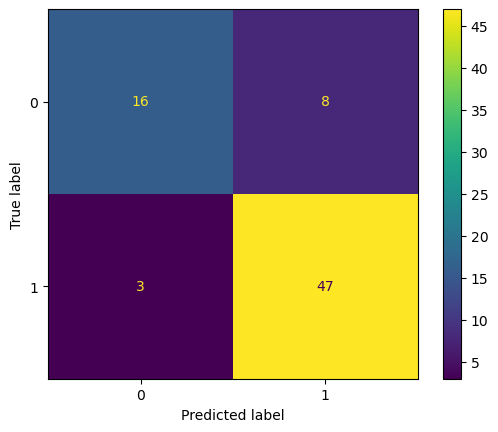

In [73]:
#import matplotlib.pyplot as plt 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

ConfusionMatrixDisplay.from_estimator(models[2], X_val, Y_val)
plt.show()

In [74]:
# Let's plot the classification report as well for the validation data using the SVC model.
print(metrics.classification_report(Y_val,
                                    models[2].predict(X_val)))

              precision    recall  f1-score   support

           0       0.84      0.67      0.74        24
           1       0.85      0.94      0.90        50

    accuracy                           0.85        74
   macro avg       0.85      0.80      0.82        74
weighted avg       0.85      0.85      0.85        74

